In [1]:
import os, sys
import glob
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [67]:
data_path = "/home/ubuntu/anudeep/machine_sound/"

# Direct paths to audio files
paths = glob.glob(data_path+"0_dB_fan/*/id_00/*/*")[0:100]
paths.sort()

In [114]:
from tqdm import trange

class MIMII(Dataset):
    def __init__(self, data_paths):
        
        # Parameters for conversion to MEL spectrogram 
        self.n_mels = 64
        self.frames = 5
        self.n_fft = 2048
        self.hop_length = 512
        self.power = 2.0
        self.data_paths = data_paths
        
        # convert audio to spectograms
        self.spectrograms = []
        self.sampling_rates = []
        self.labels = []
        
        t = trange(len(data_paths), desc='Converting audio files to spectrograms', leave=True)        
        for index in t:
            t.set_description("Converting audio file no. %i of %i" % (index, len(data_paths)))
            t.refresh()
            
            wav_file_path = data_paths[index]
            if "abnormal" in wav_file_path:
                curr_label = 1
            elif "normal" in wav_file_path:
                curr_label = 0
            else:
                curr_label = -1
            
            curr_spectrogram, curr_sr = self.convert_to_spectrogram(wav_file_path)
            self.spectrograms.append(curr_spectrogram)
            self.labels.append(curr_label)
            self.sampling_rates.append(curr_sr)
            
            
    def __getitem__(self, index):
        
        # return and indexed item from the list
        # NOTE: There are 8 spectrograms per audio, one for each microphone
        return torch.from_numpy(self.spectrograms[index]), torch.from_numpy(np.array([self.labels[index]])),\
    torch.from_numpy(self.sampling_rates[index])
    
        
    def __len__(self):
        
        # number of samples loaded
        return len(self.data_paths)
    
        
    def convert_to_spectrogram(self, wav_file_path):
        signal, sampling_rate = self.load_sound_file(wav_file_path)
        
#         ## Perform fourier transform
#         stft = librosa.stft(signal, n_fft=self.n_fft, hop_length=self.hop_length)
#         # Map the magnitude to a decibel scale:
#         dB = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        
        ## Mel spectrogram calculation
        db_mels = []
        for channel in range(signal.shape[0]):
            mel = librosa.feature.melspectrogram(signal[channel], sr=sampling_rate, n_fft=self.n_fft, hop_length=self.hop_length,\
                                             n_mels=self.n_mels)
            db_mel = librosa.power_to_db(mel, ref=np.max)
            db_mels.append(db_mel)
        
        return np.array(db_mels), np.array(sampling_rate)
        
    
    def load_sound_file(self, wav_name, mono=False, channel=0):
        multi_channel_data, sampling_rate = librosa.load(wav_name, sr=None, mono=mono)
        signal = np.array(multi_channel_data)
    
        return signal, sampling_rate
    
    transform = T.Compose([T.ToPILImage(), T.ToTensor()])
        

In [115]:
dataset = MIMII(paths)

Converting audio file no. 99 of 100: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


In [116]:
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=2)
iterable = iter(dataloader)

In [117]:
x, y, z = iterable.next()

# Visualization of spectrograms

(1, 8, 64, 313) [[1]] (1,)


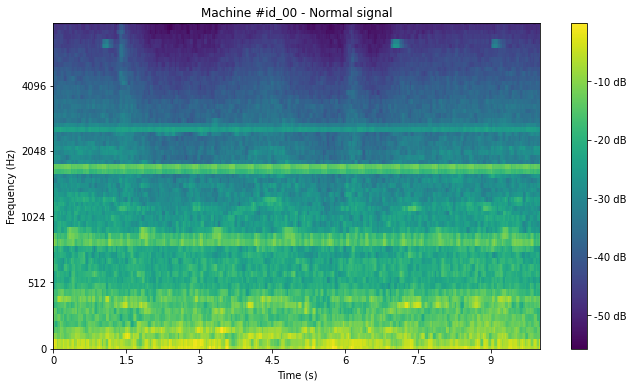

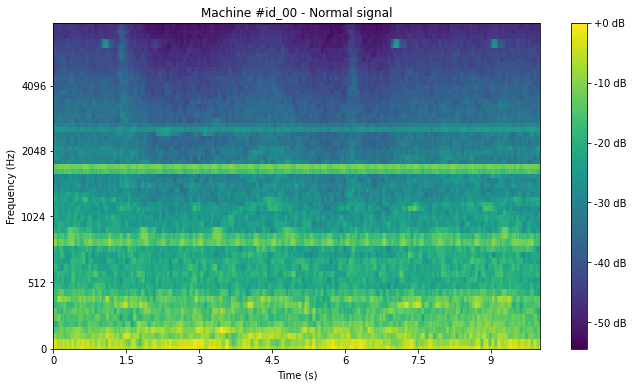

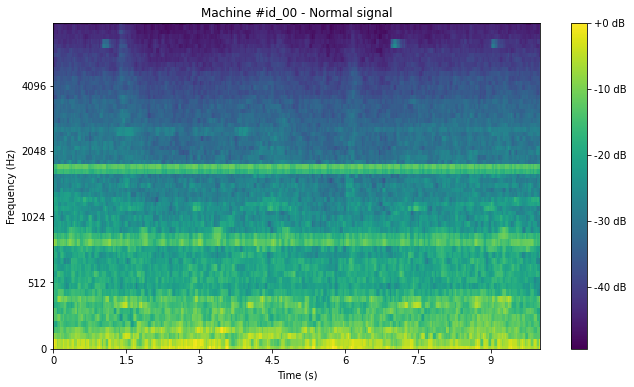

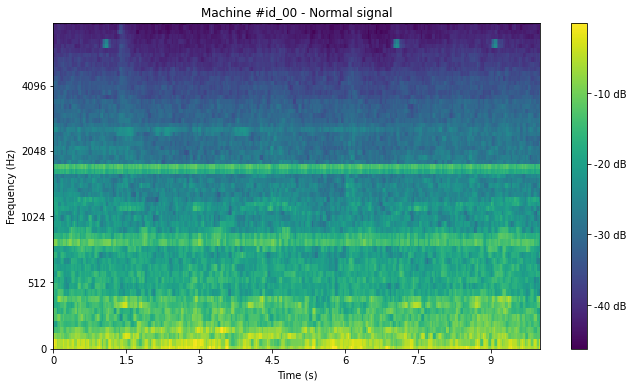

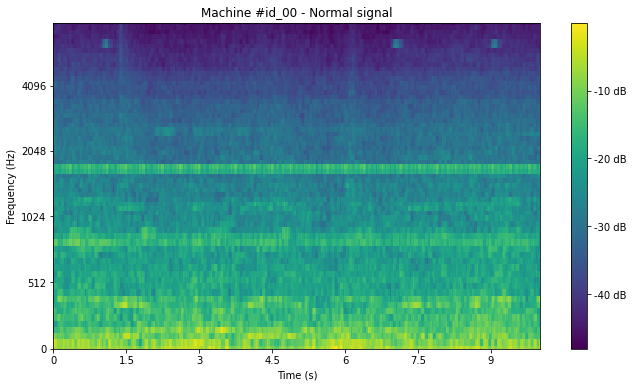

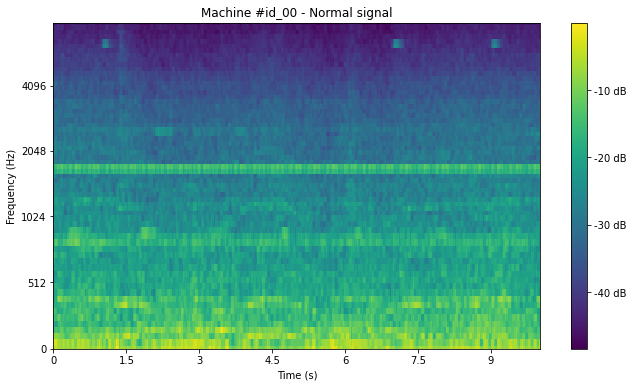

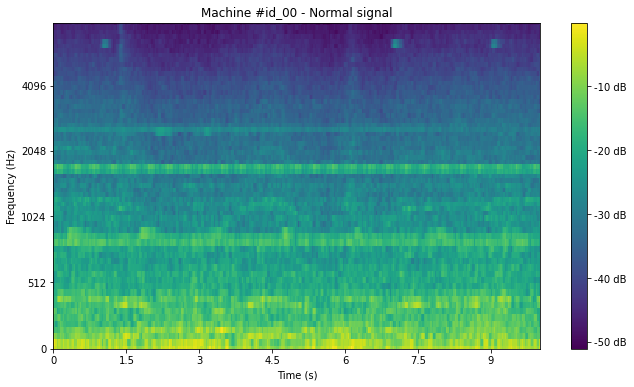

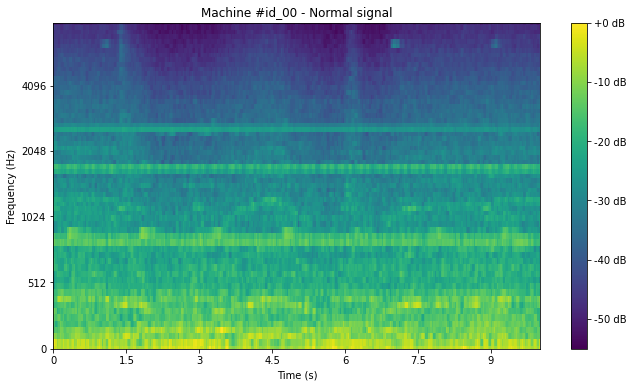

In [121]:
x_np = x.numpy()
y_np = y.numpy()
z_np = z.numpy()
print(x_np.shape, y_np, z_np.shape)

#f, ax = plt.figure(2, 4)

for k in range(8):
    fig = plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    librosa.display.specshow(x_np[0][k], sr=z_np[0], hop_length=512, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title('Machine #id_00 - Normal signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')

In [ ]:
# Data loader for images - please ignore this for now
'''
from tqdm import trange
from collections import defaultdict

class MIMII(Dataset):
    def __init__(self, base_path, snr, machine):
        
        # Parameters for conversion to MEL spectrogram 
        self.n_mels = 64
        self.frames = 5
        self.n_fft = 2048
        self.hop_length = 512
        self.power = 2.0
        self.base_path = base_path
        assert type(machine) == list
        assert len(machine) > 1
        
        # group paths by unique audio file
        self.normal_paths = glob.glob(base_path + "normal/{}*.png".format(snr))
        self.normal_paths.sort()
        self.abnormal_paths = glob.glob(base_path + "abnormal/{}*.png".format(snr))
        self.abnormal_paths.sort()
        self.normal_file_count = len(self.normal_paths) / 8
        self.abnormal_file_count = len(self.abnormal_paths) / 8
        self.normal_files = defaultdict(list)
        self.abnormal_files = defaultdict(list)
        
        for f in self.normal_paths:
            file_name = f.split("/")[-1][:-8]
            
            if file_name in self.normal_files.keys():
                self.normal_files[file_name].append(f)
            
            else:
                self.normal_files[file_name] = [f]
        
        # NOTE: We aren't using abnormal files in the current setting. This is to support future experiments
        for f in self.abnormal_paths:
            file_name = f.split("/")[-1][:-8]
            
            if file_name in self.abnormal_files.keys():
                self.abnormal_files[file_name].append(f)
            
            else:
                self.abnormal_files[file_name] = [f]
        
        self.label_map = {s:ctr for ctr, s in enumerate(machine)}
        print("label_map: {}".format(self.label_map))          
            
            
    def __getitem__(self, index):
        
        # return and indexed item from the list
        # NOTE: There are 8 spectrograms per audio, one for each microphone
        key = list(self.normal_files.keys())[index]
        img_file_list = self.normal_files[key]
        images = []
        
        for f in img_file_list:
            img = np.asarray(Image.Image.open(f))
            images.append(img)
            
        _machine = key.split('-')[0].split('_')[-1]
        label = self.label_map[_machine]
        
        return torch.from_numpy(np.array(images)), torch.from_numpy(np.array([label]))
        
        
    def __len__(self):
        
        # number of samples loaded
        return int(self.normal_file_count)
    
        
    transform = T.Compose([T.ToTensor()])
''''

In [17]:
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
import glob
import yaml
import typing as tp
from torch.utils.data import Dataset,DataLoader
sys.path.append('../src/')
from dataset_npy import SpectrogramDataset

def get_loaders_for_training(
    args_dataset: tp.Dict, args_loader: tp.Dict,
    train_file_list: tp.List[str], val_file_list: tp.List[str]
):
    # # make dataset
    train_dataset = SpectrogramDataset(train_file_list, **args_dataset)
    val_dataset = SpectrogramDataset(val_file_list, **args_dataset)
    # # make dataloader
    train_loader = DataLoader(train_dataset, **args_loader["train"])
    val_loader = DataLoader(val_dataset, **args_loader["val"])

    return train_loader, val_loader, train_dataset, val_dataset

tmp_list = []
npz_files = glob.glob('../../../data/' + '/*/*')
for npz_file in npz_files:
    wav_fpath = npz_file
    wav_fname = npz_file.split('/')[-1]
    machine_db_type, operation_type, machine_id, file_id, channel_no = npz_file.split('/')[-1].split('-')
    machine_type = machine_db_type.split('_')[-1]
    tmp_list.append( [machine_type, machine_id, operation_type,
                                         wav_fname, wav_fpath])


train_all = pd.DataFrame(
    tmp_list, columns=["machine_type", "id_type", "operation_type",
                        "wav_filename", "wav_file_path"])

print(train_all.sample(n=5, random_state=1))
print('All df shape ', train_all.shape)

train_df, test_df = train_test_split(train_all, test_size=0.15, random_state=1234)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=1234)

print('Train df shape ', train_df.shape)
print('Test df shape ', val_df.shape)

#TODO: Here we can select to use only normal or abnormal data for training

train_file_list = train_df[["wav_file_path", "machine_type"]].values.tolist()
val_file_list = val_df[["wav_file_path", "machine_type"]].values.tolist()

print("train: {}, val: {}".format(len(train_file_list), len(val_file_list)))

with open('../params/train_config_metricLearning.yaml') as settings_str:
    settings = yaml.safe_load(settings_str)

for k, v in settings.items():
    print("[{}]".format(k))
    print(v)

#set_seed(settings["globals"]["seed"])
#device = torch.device(settings["globals"]["device"])
#output_dir = Path(settings["globals"]["output_dir"])

# # # get loader
train_loader, valid_loader, train_dataset, valid_dataset = get_loaders_for_training(
    settings["dataset"]["params"], settings["loader"], train_file_list, val_file_list)

      machine_type id_type operation_type  \
23392       slider   id_02         normal   
16946          fan   id_06         normal   
33934         pump   id_06         normal   
37262         pump   id_04         normal   
10030          fan   id_02         normal   

                                     wav_filename  \
23392   0_dB_slider-normal-id_02-00000210-ch0.npz   
16946      6_dB_fan-normal-id_06-00000688-ch0.npz   
33934     0_dB_pump-normal-id_06-00000910-ch0.npz   
37262  neg6_dB_pump-normal-id_04-00000448-ch0.npz   
10030   neg6_dB_fan-normal-id_02-00000151-ch0.npz   

                                           wav_file_path  
23392  ../../../data/normal/0_dB_slider-normal-id_02-...  
16946  ../../../data/normal/6_dB_fan-normal-id_06-000...  
33934  ../../../data/normal/0_dB_pump-normal-id_06-00...  
37262  ../../../data/normal/neg6_dB_pump-normal-id_04...  
10030  ../../../data/normal/neg6_dB_fan-normal-id_02-...  
All df shape  (54057, 5)
Train df shape  (39055, 5)
Test

In [18]:
train_iter = iter(train_loader)

../src/dataset_npy.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float16)
../src/dataset_npy.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float16)


In [23]:
x, y = train_iter.next()
x = x.numpy()

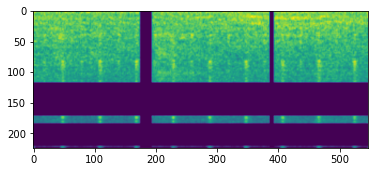

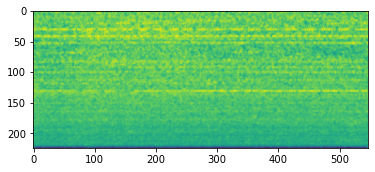

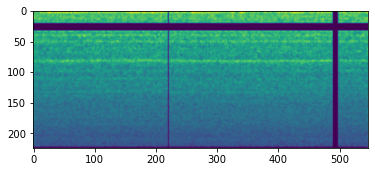

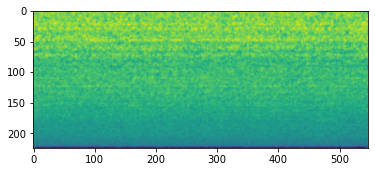

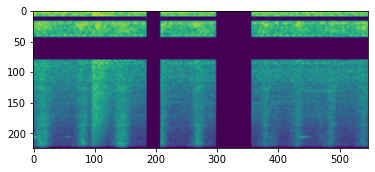

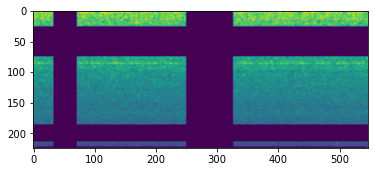

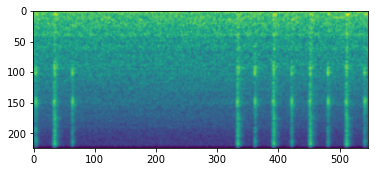

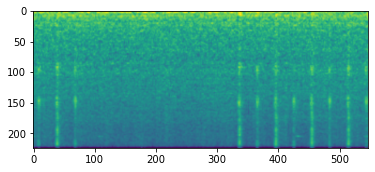

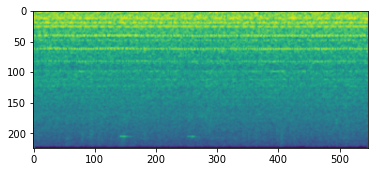

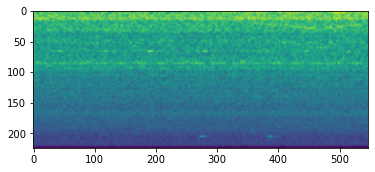

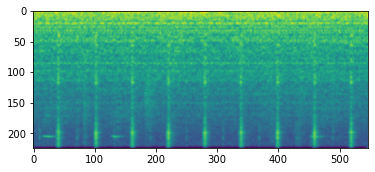

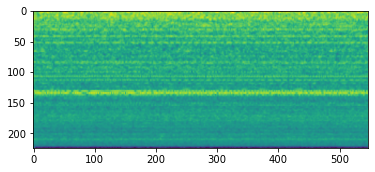

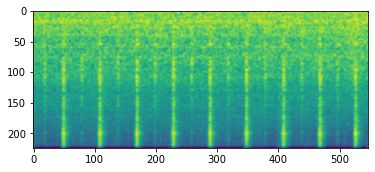

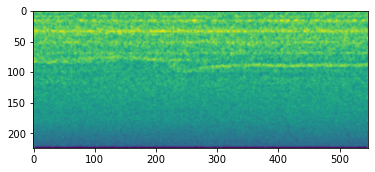

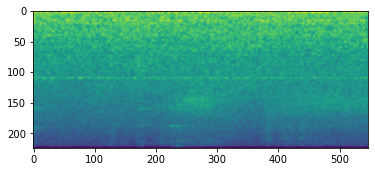

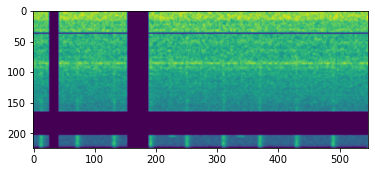

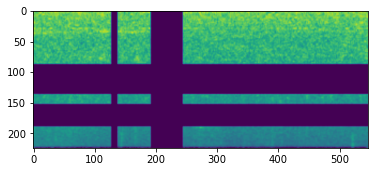

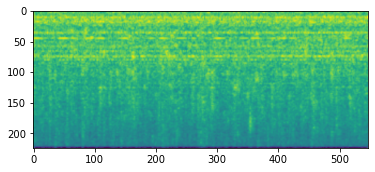

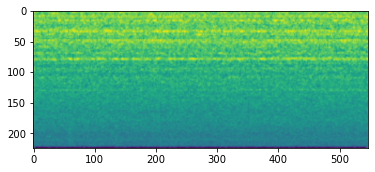

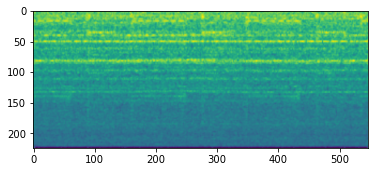

In [27]:
import matplotlib.pyplot as plt
for k in range(20):
    plt.imshow(x[k][0])
    plt.show()